# CI project :Natural-inspired pattern Recognition for Classification Proplem



### Hyperparameter Optimization (HPO) of Machine Learning Models
####  Tradional Algorithms versus Natural inspired Algorithms

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split ,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix ,classification_report,accuracy_score
from sklearn import datasets
from sklearn.svm import SVC ,SVR
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor


## Load MNIST dataset
The MNIST database  is a large database of handwritten digits that is commonly used for training various image processing systems. The MNIST database has a training set of 60,000 examples, and a test set of 10,000 examples.

In [2]:
dataset = datasets.load_digits()
X = dataset.data
y = dataset.target

In [3]:
dataset

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

## Baseline Machine Learning Models: Classifiers with Default Hyperparameters

### Using 3-Fold Cross-Validation

In [4]:
#SVM
clf = SVC()
clf.fit(X,y)
scores = cross_val_score(clf, X ,y, cv=3 , scoring ='accuracy')
print("Accuracy:"+ str(scores.mean()))


Accuracy:0.9699499165275459


## Tradition Parameter tunning Methods  Algorithm 1: Grid Search
Search all the given hyper-parameter configurations

**Advantages:**
* Simple implementation.  

**Disadvantages:**  
* Time-consuming,
* Only efficient with categorical HPs.

In [5]:
# SVM optimized by GridSearchCv
from sklearn.model_selection import GridSearchCV
#Define hyperparameter Configuration space
svm_params = {
    'C':[1, 10, 100],
    'kernel' :['linear','poly','rbf','sigmoid']
}
clf = SVC(gamma='scale')
grid =GridSearchCV(clf,svm_params ,cv=3 ,scoring = 'accuracy')
grid.fit(X,y)
print(grid.best_params_)
print("Accuracy:"+str(grid.best_score_))
svc_accuracy_bygridsearch = grid.best_score_
svc_params_bygridsearch = grid.best_params_

{'C': 10, 'kernel': 'rbf'}
Accuracy:0.9738452977184195


##  Algorithm 2: Random Search
Randomly search hyper-parameter combinations in the search space

**Advantages:**
* More efficient than GS.
* Enable parallelization.

**Disadvantages:**  
* Not consider previous results.
* Not efficient with conditional HPs.

In [6]:
#SVM
from scipy import stats
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
rf_params = {
    'C': stats.uniform(0,50),
    "kernel":['linear','poly','rbf','sigmoid']
}
n_iter_search=20
clf = SVC(gamma='scale')
Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
Random.fit(X, y)
print(Random.best_params_)
print("Accuracy:"+ str(Random.best_score_))
svc_accuracy_byrandomsearch = Random.best_score_
svc_params_byrandomsearch = Random.best_params_

{'C': 16.572560922601255, 'kernel': 'rbf'}
Accuracy:0.9738452977184195


## Run local search BFO  optimization
Execute the local search BFO  algorithm to optimize SVM hyperparameters (C , gama and kernel).across generations.



BFO Optimized SVM Parameters:
Best C: 24.4214
Best gamma: 0.000122
Best kernel: poly
Cross-Validation Accuracy: 96.7168%


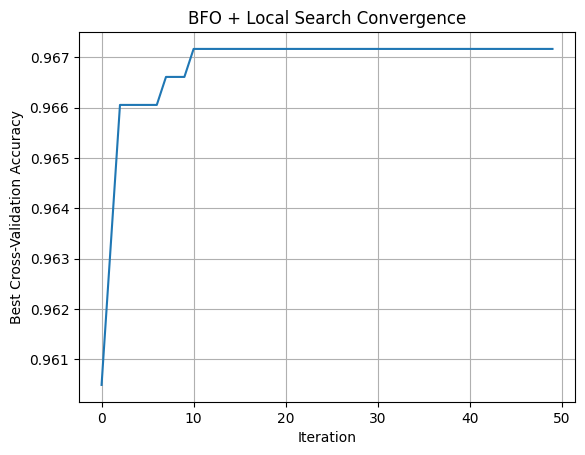

In [4]:

from sklearn.model_selection import cross_val_score
from functools import lru_cache

# --- Parameter ranges ---
C_min, C_max = 0.1, 100
gamma_min, gamma_max = 1e-4, 1
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# --- BFO Parameters ---
pop_size = 20
num_chemotaxis = 10
num_reproduction = 5
step_size = 0.2
p_ed = 0.2

# --- Fitness Function (cached, using cross-validation) ---
@lru_cache(maxsize=None)
def fitness(C, gamma, kernel_idx):
    kernel = kernels[int(kernel_idx)]
    model = SVC(C=C, gamma=gamma, kernel=kernel)
    scores = cross_val_score(model, X, y, cv=3, scoring='accuracy')
    return scores.mean()

# --- Chemotaxis ---
def chemotaxis(bacterium, step_size):
    C, gamma, kernel_idx = bacterium
    C_new = np.clip(C * (1 + step_size * np.random.uniform(-1, 1)), C_min, C_max)
    gamma_new = np.clip(gamma * (1 + step_size * np.random.uniform(-1, 1)), gamma_min, gamma_max)
    kernel_idx_new = np.random.randint(0, len(kernels)) if np.random.rand() < 0.1 else kernel_idx
    return (C_new, gamma_new, kernel_idx_new)

# --- Local Search ---
def local_search(bacterium):
    C, gamma, kernel_idx = bacterium
    best_C, best_gamma, best_kernel_idx = C, gamma, kernel_idx
    best_fit = fitness(C, gamma, kernel_idx)

    # Search small deltas around C
    for delta in [-0.1, 0.1]:
        C_try = np.clip(C + delta, C_min, C_max)
        fit_try = fitness(C_try, gamma, kernel_idx)
        if fit_try > best_fit:
            best_fit = fit_try
            best_C = C_try

    # Search small deltas around gamma
    for delta in [-0.01, 0.01]:
        gamma_try = np.clip(gamma + delta, gamma_min, gamma_max)
        fit_try = fitness(best_C, gamma_try, kernel_idx)
        if fit_try > best_fit:
            best_fit = fit_try
            best_gamma = gamma_try

    # Try different kernels
    for k in range(len(kernels)):
        if k != kernel_idx:
            fit_try = fitness(best_C, best_gamma, k)
            if fit_try > best_fit:
                best_fit = fit_try
                best_kernel_idx = k

    return (best_C, best_gamma, best_kernel_idx)

# --- Initialize population ---
population = [(np.random.uniform(C_min, C_max),
               np.random.uniform(gamma_min, gamma_max),
               np.random.randint(0, len(kernels)))
              for _ in range(pop_size)]

# --- Main BFO loop ---
history = []
for repro in range(num_reproduction):
    for chemo in range(num_chemotaxis):
        for i in range(pop_size):
            new_bacterium = chemotaxis(population[i], step_size)
            new_bacterium = local_search(new_bacterium)
            if fitness(*new_bacterium) > fitness(*population[i]):
                population[i] = new_bacterium
        best_bact = max(population, key=lambda b: fitness(*b))
        history.append(fitness(*best_bact))

    population = sorted(population, key=lambda b: fitness(*b), reverse=True)
    population = population[:pop_size//2] + population[:pop_size//2]

    for i in range(pop_size):
        if np.random.rand() < p_ed:
            population[i] = (np.random.uniform(C_min, C_max),
                             np.random.uniform(gamma_min, gamma_max),
                             np.random.randint(0, len(kernels)))

# --- Results ---
best_bact = max(population, key=lambda b: fitness(*b))
best_C, best_gamma, best_kernel_idx = best_bact
best_kernel = kernels[int(best_kernel_idx)]
best_acc = fitness(best_C, best_gamma, best_kernel_idx)

print(f"\nBFO Optimized SVM Parameters:")
print(f"Best C: {best_C:.4f}")
print(f"Best gamma: {best_gamma:.6f}")
print(f"Best kernel: {best_kernel}")
print(f"Cross-Validation Accuracy: {best_acc:.4%}")

# --- Plot convergence ---
plt.plot(history)
plt.xlabel('Iteration')
plt.ylabel('Best Cross-Validation Accuracy')
plt.title('BFO + Local Search Convergence')
plt.grid()
plt.savefig('convergence_plot.png')

## Accuracy comparison plot
Compare the accuracies of GridSearchCV, RandomizedSearchCV, and local BFO using a bar chart.


=== Accuracy Comparison ===
GridSearchCV Accuracy:     0.9738 | Params: {'C': 10, 'kernel': 'rbf'}
RandomSearchCV Accuracy:   0.9738 | Params: {'C': 16.572560922601255, 'kernel': 'rbf'}
local search BFO Accuracy:       0.9738 | Params: {'C': 240.54516129032257, 'kernel': 'rbf'}


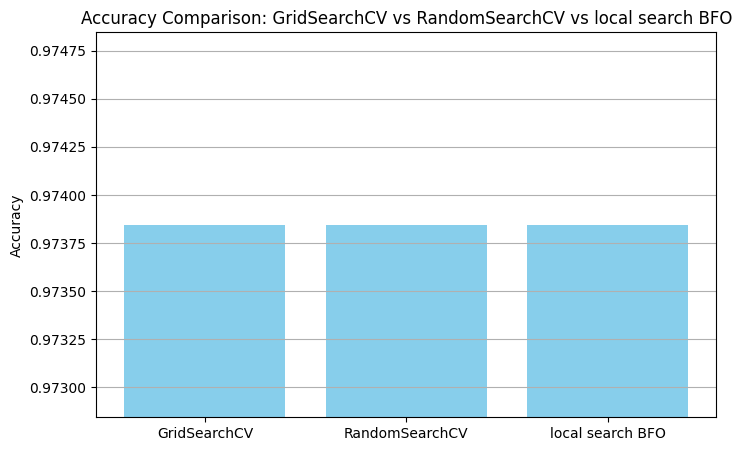

In [ ]:
print("=== Accuracy Comparison ===")
print(f"GridSearchCV Accuracy:     {svc_accuracy_bygridsearch:.4f} | Params: {svc_params_bygridsearch}")
print(f"RandomSearchCV Accuracy:   {svc_accuracy_byrandomsearch:.4f} | Params: {svc_params_byrandomsearch}")
print(f"Cross-Validation Accuracy: {best_acc:.4%}")
print(f"local search BFO Accuracy:       {best_acc:.4f} | Params: {best_bact}")


import matplotlib.pyplot as plt

results = {
    'GridSearchCV': svc_accuracy_bygridsearch,
    'RandomSearchCV': svc_accuracy_byrandomsearch,
    'local search BFO': best_acc
}

labels = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color='skyblue')
plt.ylabel('Accuracy')
plt.ylim(min(accuracies) - 0.001, max(accuracies) + 0.001)
plt.title('Accuracy Comparison: GridSearchCV vs RandomSearchCV vs local search BFO')
plt.grid(axis='y')
plt.show()
